# Метрики

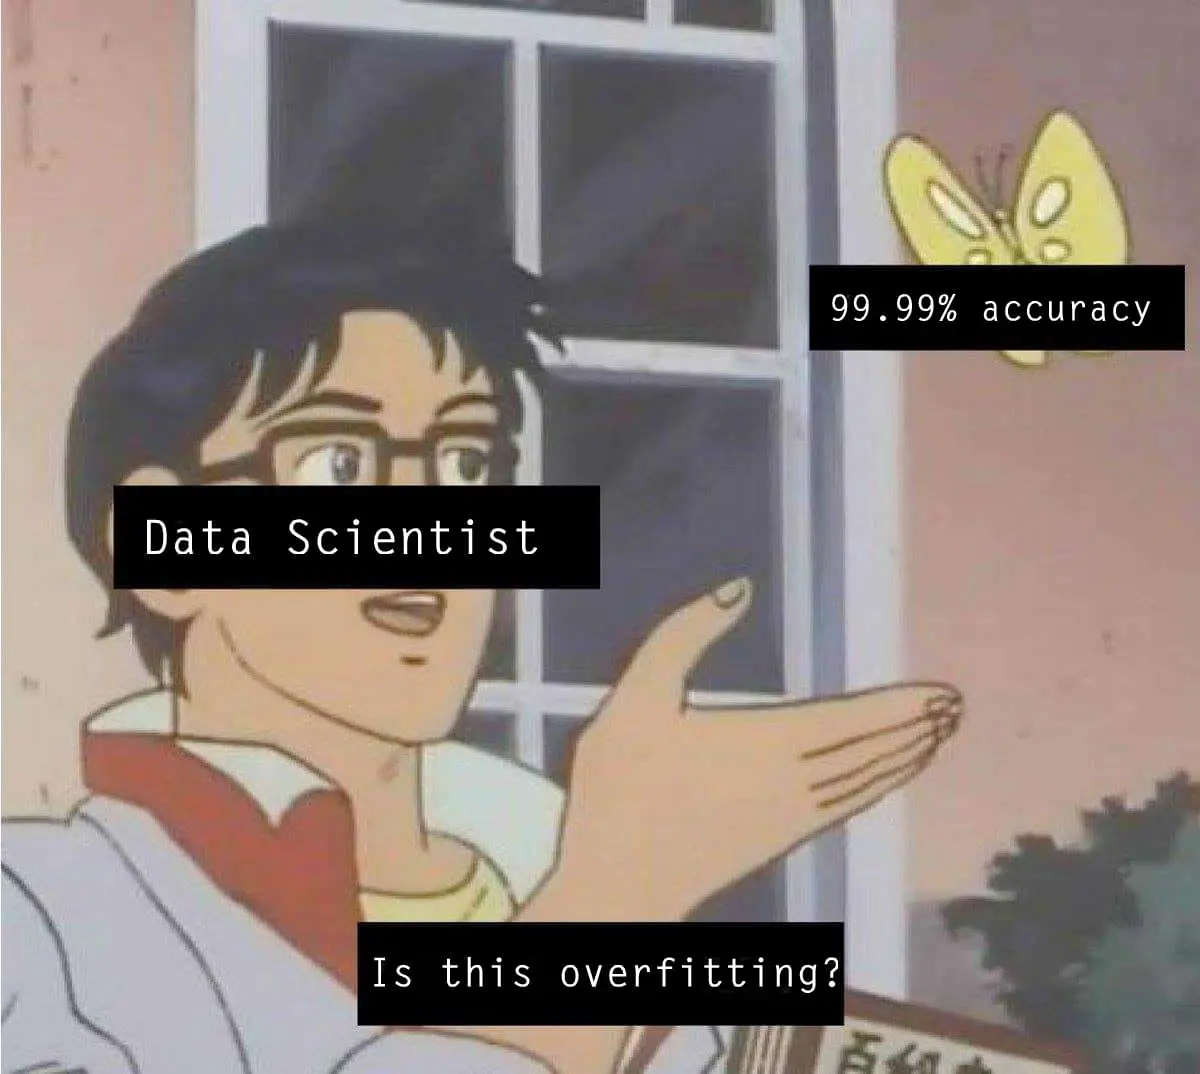

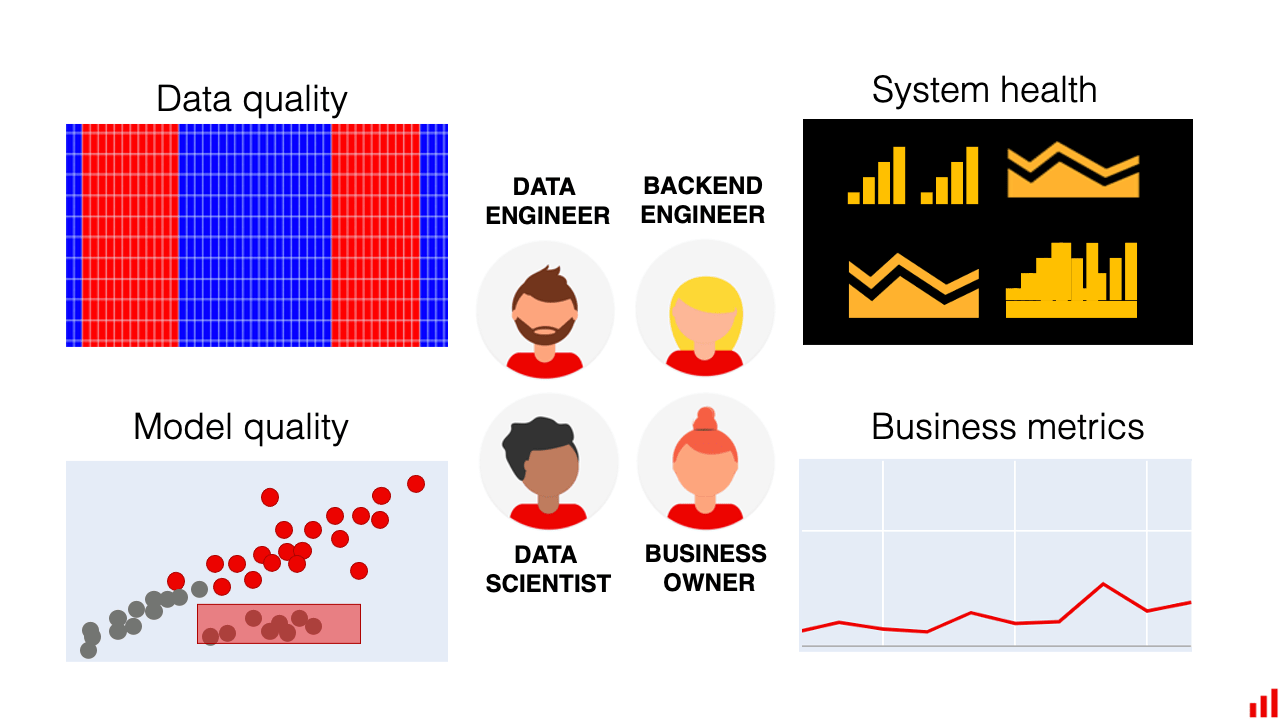

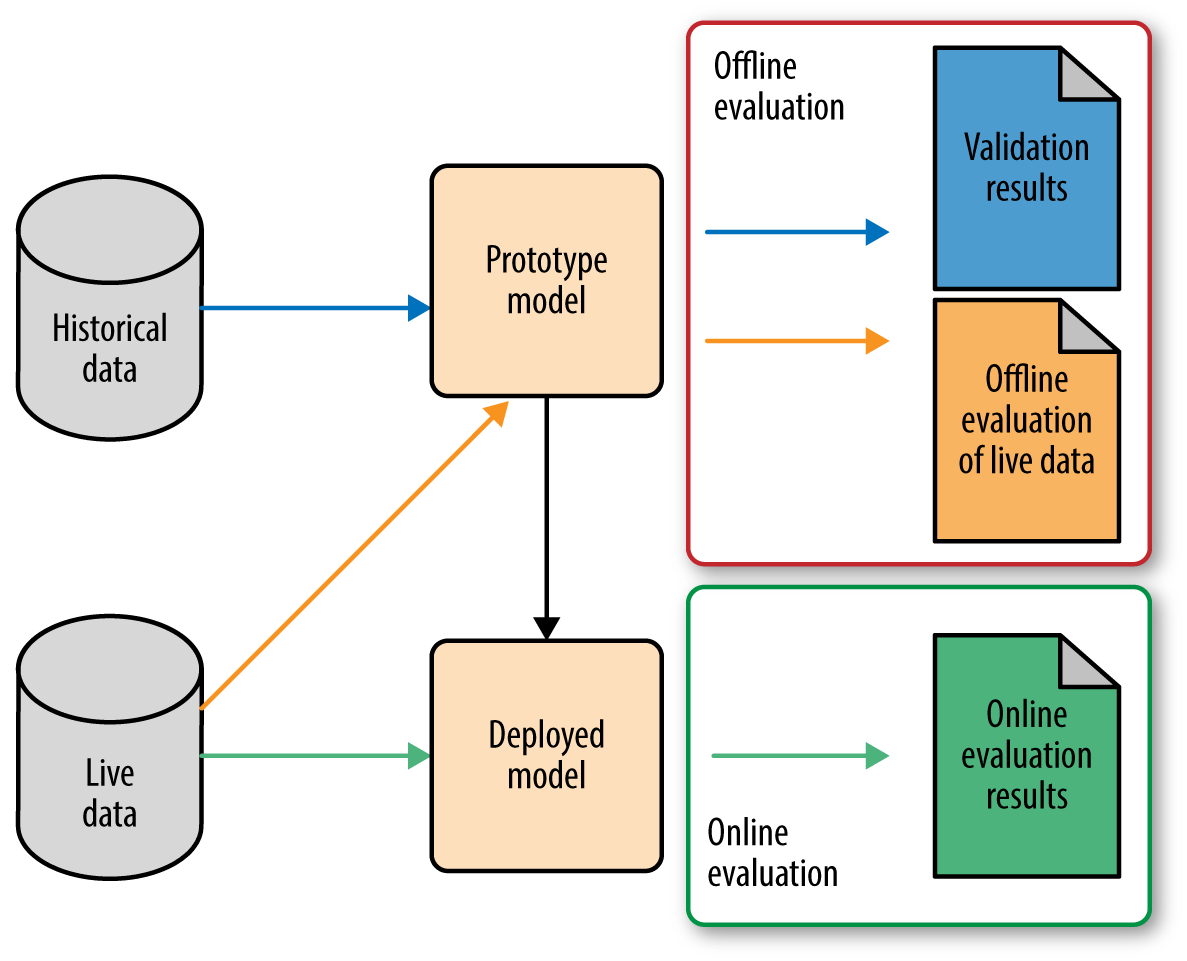

# Оффлайн метрики алгоритмов

## Регрессия

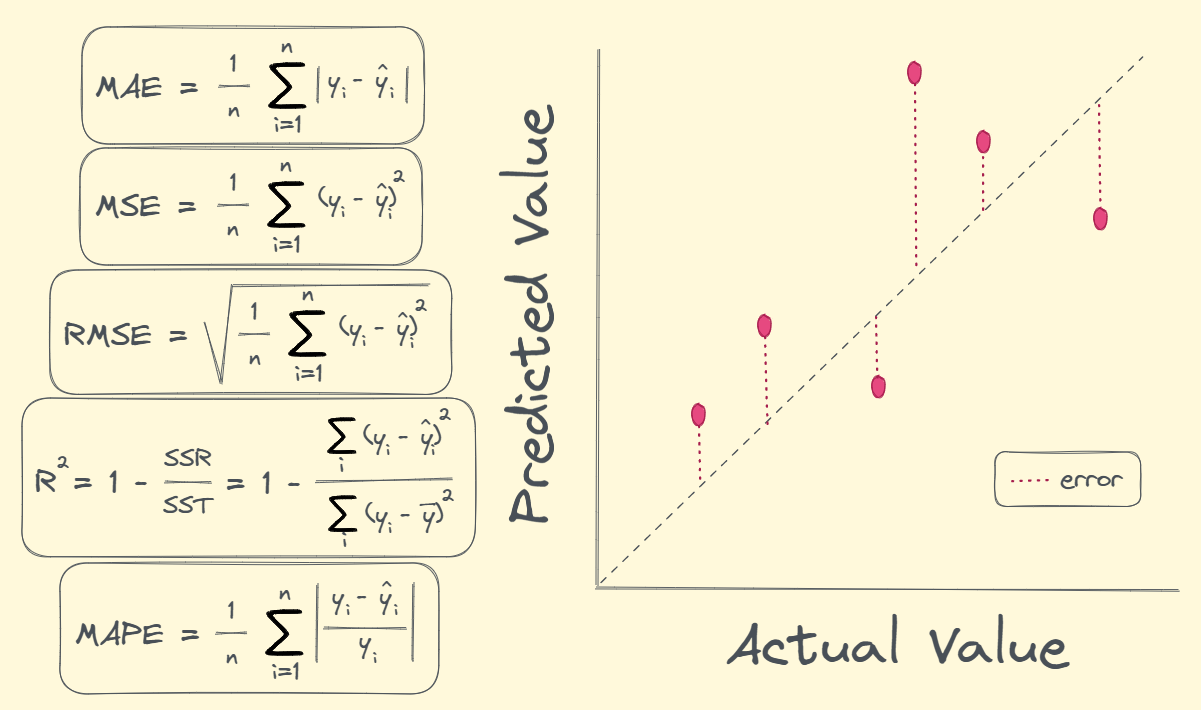

#### Mean absolute error

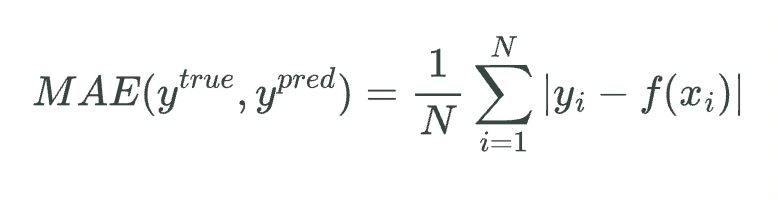

Главная проблема - не учитывает порядок величин.

Рассмотрим следующую задачу: мы хотим спрогнозировать спрос товаров на следующий месяц. Пусть у нас есть два продукта: продукт A продаётся в количестве 100 штук, а продукт В в количестве 10 штук. И пусть базовая модель предсказывает количество продаж продукта A как 98 штук, а продукта B как 8 штук. Ошибки на этих объектах добавляют 4 штрафных единицы в MAE.

И есть 2 модели-кандидата на улучшение. Первая предсказывает товар А 99 штук, а товар B 8 штук. Вторая предсказывает товар А 98 штук, а товар B 9 штук.

Обе модели улучшают MAE базовой модели на 1 единицу. Однако, с точки зрения бизнес-заказчика вторая модель может оказаться предпочтительнее, т.к. предсказание продажи редких товаров может быть приоритетнее. Один из способов учесть такое требование – рассматривать не абсолютную, а относительную ошибку на объектах.

#### Mean absolute percentage error

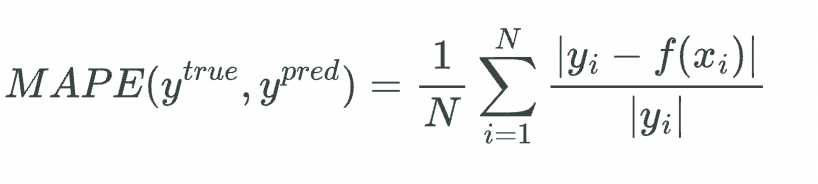

Если значение таргета 0, то можно выдавать фиксированно 0 (что не честно) или рассмотреть следующую метрику

#### Symmetric mean absolute percentage error

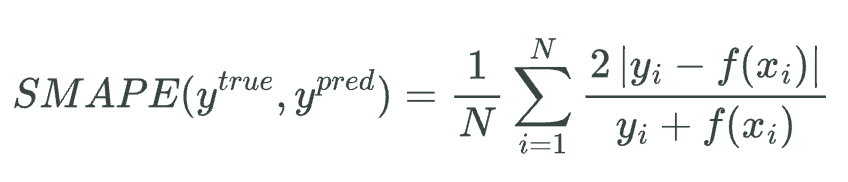

Рассмотрим следующий пример:

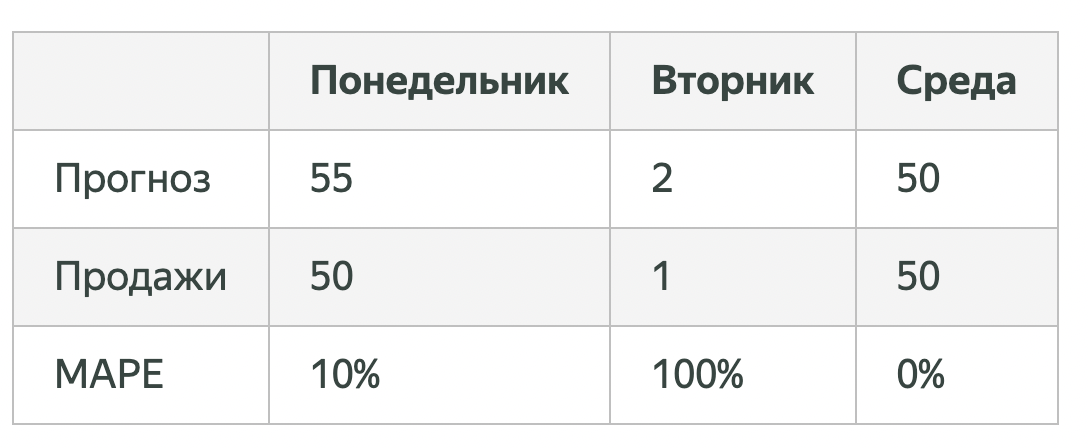

Средний MAPE 36 процентов, что странно, тк модель визуально предсказывает неплохо. Для таких кейсов можем рассмотреть следующую метрику

#### WAPE

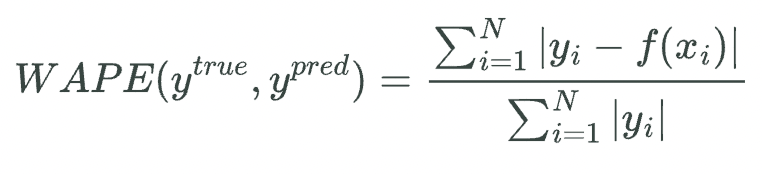

На примере выше WAPE будет 5%.

#### Mean squared error

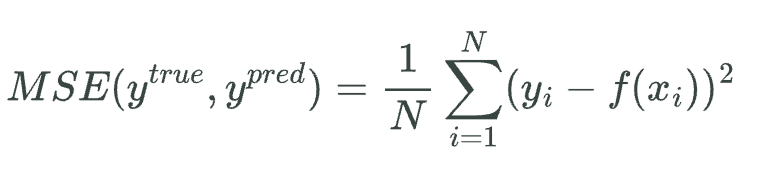

MSE неограничен сверху, и может быть нелегко понять, насколько "хорошим" или "плохим" является то или иное его значение. Чтобы появились какие-то ориентиры, делают следующее:

- Берут наилучшее константное предсказание с точки зрения MSE — среднее арифметическое меток.

- Рассматривают в качестве показателя ошибки:

  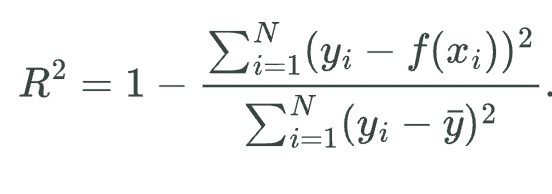

Можно заметить, что R2 показывает, какая доля дисперсии таргетов (знаменатель) объяснена моделью

MSE квадратично штрафует за большие ошибки на объектах. Мы уже видели проявление этого при обучении моделей методом минимизации квадратичных ошибок – там это проявлялось в том, что модель старалась хорошо подстроиться под выбросы.

Пусть теперь мы хотим использовать MSE для оценки наших регрессионных моделей. Если большие ошибки для нас действительно неприемлемы, то квадратичный штраф за них - очень полезное свойство (и его даже можно усиливать, повышая степень, в которую мы возводим ошибку на объекте). Однако если в наших тестовых данных присутствуют выбросы, то нам будет сложно объективно сравнить модели между собой: ошибки на выбросах будет маскировать различия в ошибках на основном множестве объектов.

Таким образом, если мы будем сравнивать две модели при помощи MSE, у нас будет выигрывать та модель, у которой меньше ошибка на объектах-выбросах, а это, скорее всего, не то, чего требует от нас наша бизнес-задача.

#### Доля предсказаний с абсолютными ошибками больше, чем d

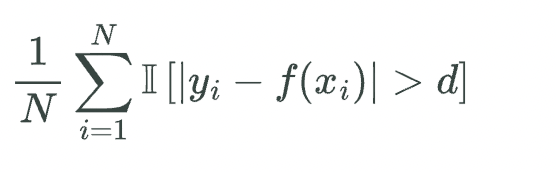

#### Code part

In [19]:
import pandas as pd
from catboost import CatBoostRegressor
import sklearn.metrics as metrics

model = CatBoostRegressor(verbose=False)

train_dt = pd.read_csv('assets/regression_train.csv').dropna()
test_dt = pd.read_csv('assets/regression_test.csv').dropna()

train_dt.head(3)

beds  baths    size size_units  lot_size lot_size_units  zip_code     price
0     3    2.5  2590.0       sqft   6000.00           sqft     98144  795000.0
1     4    2.0  2240.0       sqft      0.31           acre     98106  915000.0
2     4    3.0  2040.0       sqft   3783.00           sqft     98107  950000.0

In [20]:
train_dt['price'].mean(), test_dt['price'].mean()

(1038475.2115038945, 1045011.3271028037)

In [21]:
model.fit(
    X=train_dt.drop(['price'], axis=1),
    y=train_dt['price'],
    cat_features=['beds', 'size_units', 'lot_size_units', 'zip_code']
)

y = test_dt['price']
preds = model.predict(test_dt.drop(['price'], axis=1))

In [24]:
print(f'MSE: {metrics.mean_squared_error(preds, y)}')
print(f'RMSE: {metrics.mean_squared_error(preds, y, squared=False)}')
print(f'R2: {metrics.r2_score(preds, y)}')

MSE: 251399042991.58896
RMSE: 501397.0911279691
R2: 0.2371442044952865


In [31]:
import numpy as np

def smape(p, t):
    return np.sum(2 * np.abs(p - t) / (np.abs(p) + np.abs(t))) / len(p)

def wape(p, t):
    return np.sum(np.abs(p - t)) / np.sum(np.abs(t))

In [32]:
print(f'MAE: {metrics.mean_absolute_error(preds, y)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(preds, y)}')
print(f'SMAPE: {smape(preds, y)}')
print(f'WAPE: {wape(preds, y)}')

MAE: 257103.6991507787
MAPE: 0.20247988326265082
SMAPE: 0.2111932672402327
WAPE: 0.24602958119466004


In [33]:
def num_threshold(p, t, threshold=0.0):
    return sum(np.abs(p - t) > threshold) / len(p)

for threshold in [0, 1e5, 5e5, 1e6, 2e6]:
    print(f'threshold {threshold}: {num_threshold(preds, y, threshold)}')

threshold 0: 1.0
threshold 100000.0: 0.572429906542056
threshold 500000.0: 0.12383177570093458
threshold 1000000.0: 0.04205607476635514
threshold 2000000.0: 0.011682242990654205


## Классификация

Сначала рассмотрим кейс бинарной классификации (2 класса). На мультиклассовый кейс все перечеисленное легко обобщается.

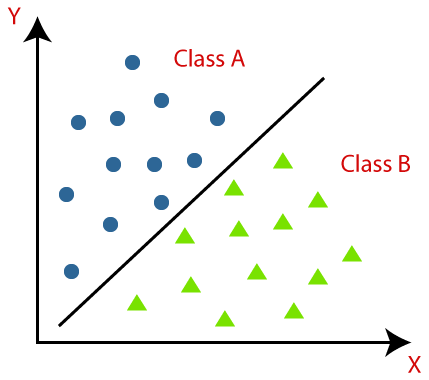

#### Accuracy

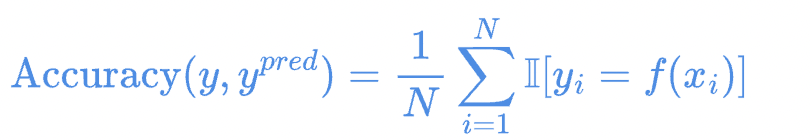

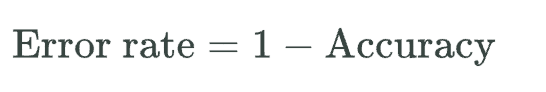

Познакомившись чуть внимательнее с этой метрикой, можно заметить, что у неё есть несколько недостатков:

- она не учитывает дисбаланс классов. Например, в задаче диагностики редких заболеваний классификатор, предсказывающий всем пациентам отсутствие болезни будет иметь достаточно высокую accuracy просто потому, что больных людей в выборке намного меньше

- она также не учитывает цену ошибки на объектах разных классов. Для примера снова можно привести задачу медицинской диагностики: если ошибочный положительный диагноз для здорового больного обернётся лишь ещё одним обследованием, то ошибочно отрицательный вердикт может повлечь роковые последствия.

#### Confusion matrix

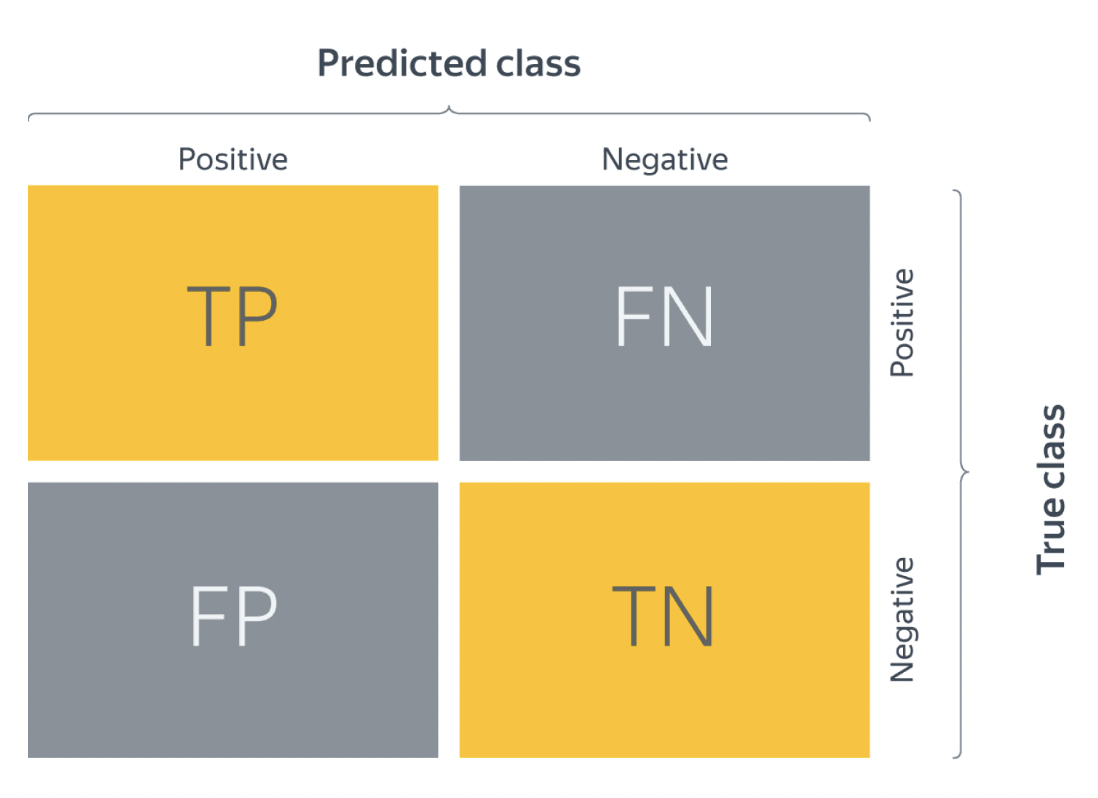

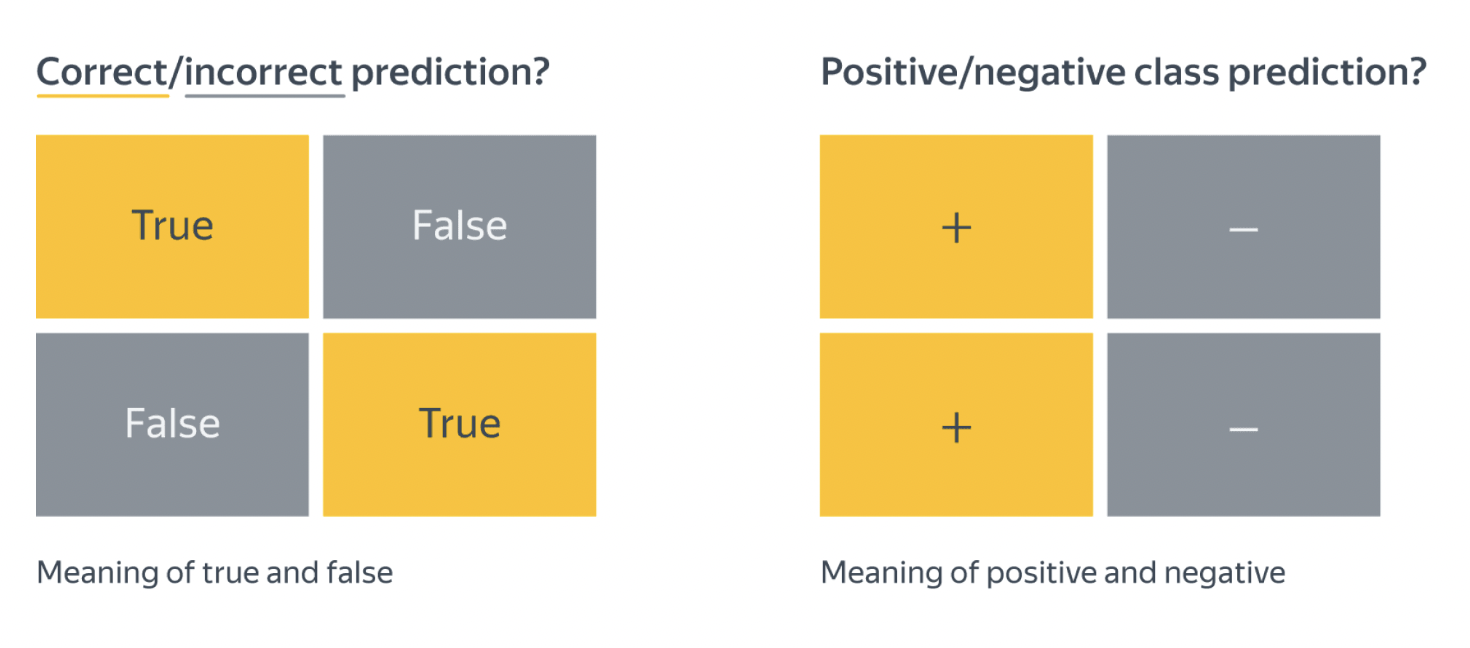

In [37]:
from sklearn.datasets import load_breast_cancer 
the_data = load_breast_cancer()    

# 0 – "доброкачественный" 
# 1 – "злокачественный" 
relabeled_target = 1 - the_data["target"] 

from sklearn.model_selection import train_test_split 
X = the_data["data"] 
y = relabeled_target 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 

from sklearn.dummy import DummyClassifier 
dc_mf = DummyClassifier(strategy="most_frequent") 
dc_mf.fit(X_train, y_train) 

from sklearn.metrics import confusion_matrix 
y_true = y_test
y_pred = dc_mf.predict(X_test) 
dc_mf_tn, dc_mf_fp, dc_mf_fn, dc_mf_tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel()

dc_mf_tn, dc_mf_fp, dc_mf_fn, dc_mf_tp

(90, 0, 53, 0)

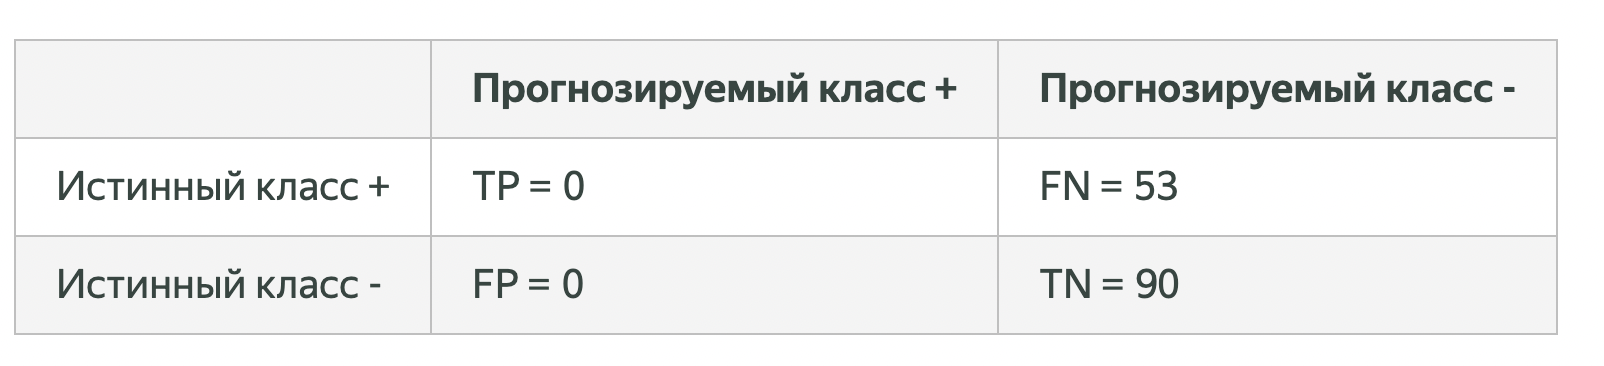

Обучающие данные таковы, что наш dummy-классификатор все объекты записывает в отрицательный класс, то есть признаёт все опухоли доброкачественными. Такой наивный подход позволяет нам получить минимальный штраф за FP (действительно, нельзя ошибиться в предсказании, если положительный класс вообще не предсказывается), но и максимальный штраф за FN (в эту группу попадут все злокачественные опухоли).

#### Precision и Recall

Если мы рассмотрим долю правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом, то мы получим метрику, которая называется точностью (precision)


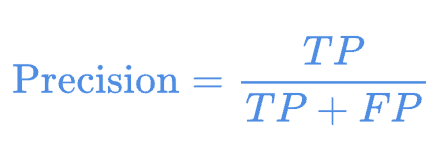

Если же мы рассмотрим долю правильно найденных положительных объектов среди всех объектов положительного класса, то мы получим метрику, которая называется полнотой (recall)

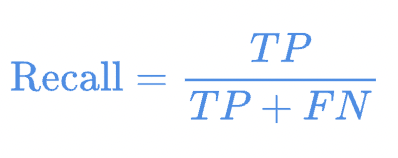

Более интуитивно:

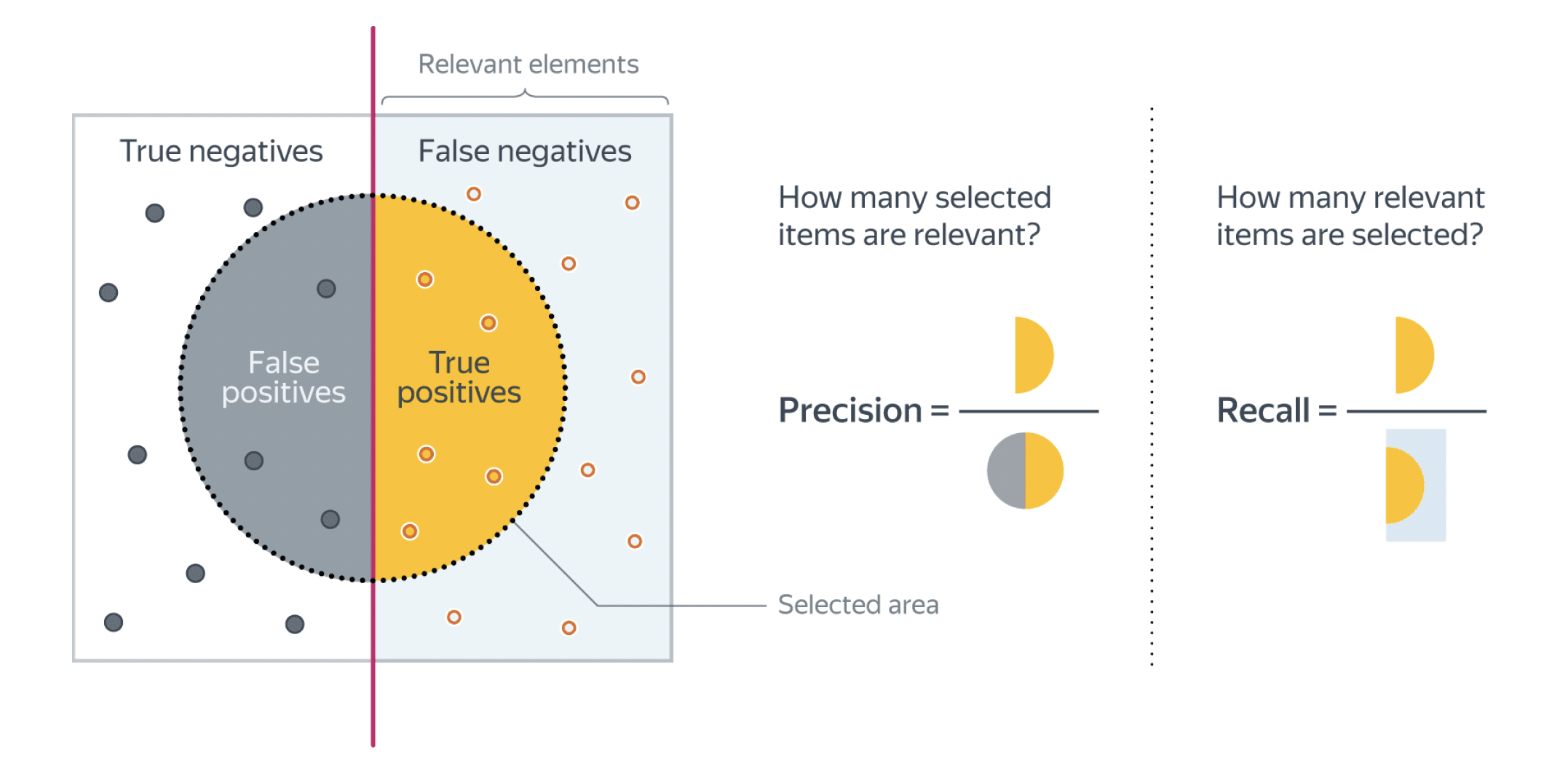

#### Recall@k и Precision@k

Метрики Recall и Precision хорошо подходят для задачи поиска «документ d релевантен запросу q», когда из списка рекомендованных алгоритмом документов нас интересует только первый. Но не всегда алгоритм машинного обучения вынужден работать в таких жестких условиях. Может быть такое, что вполне достаточно, что релевантный документ попал в первые k рекомендованных. Например, в интерфейсе выдачи первые три подсказки видны всегда одновременно и вообще не очень понятно, какой у них порядок. Тогда более честной оценкой качества алгоритма будет «в выдаче D размера k по запросу q нашлись релевантные документы». Для расчёта метрики по всей выборке объединим все выдачи и рассчитаем precision, recall как обычно подокументно.

#### F1 

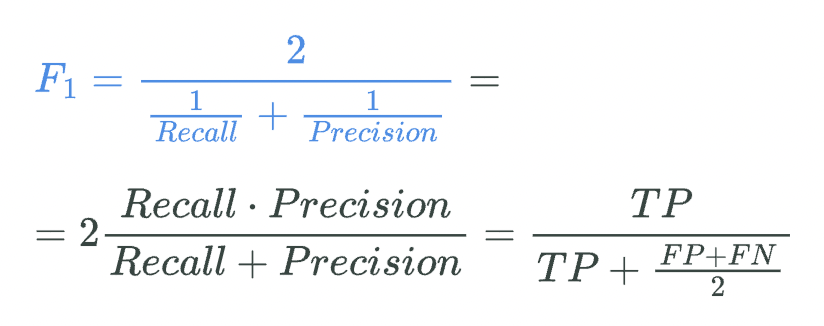

И более общая метрика F-beta:

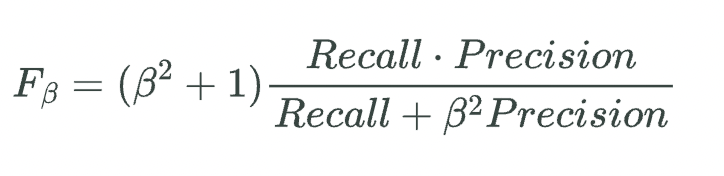

Стоит иметь в виду, что F1-мера предполагает одинаковую важность Precision и Recall, если одна из этих метрик для вас приоритетнее, то можно воспользоваться последней.

#### AUC

Пусть мы хотим учитывать ошибки на объектах обоих классов. При уменьшении порога отсечения мы будем находить (правильно предсказывать) всё большее число положительных объектов, но также и неправильно предсказывать положительную метку на всё большем числе отрицательных объектов. Естественным кажется ввести две метрики TPR и FPR:

TPR (true positive rate) – это полнота, доля положительных объектов, правильно предсказанных положительными:

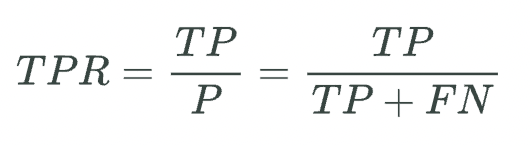

FPR (false positive rate) – это доля отрицательных объектов, неправильно предсказанных положительными:

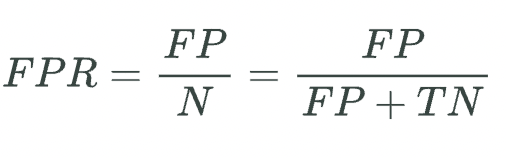

Обе эти величины растут при уменьшении порога. Кривая в осях TPR/FPR, которая получается при варьировании порога, исторически называется ROC-кривой (receiver operating characteristics curve, сокращённо ROC curve)

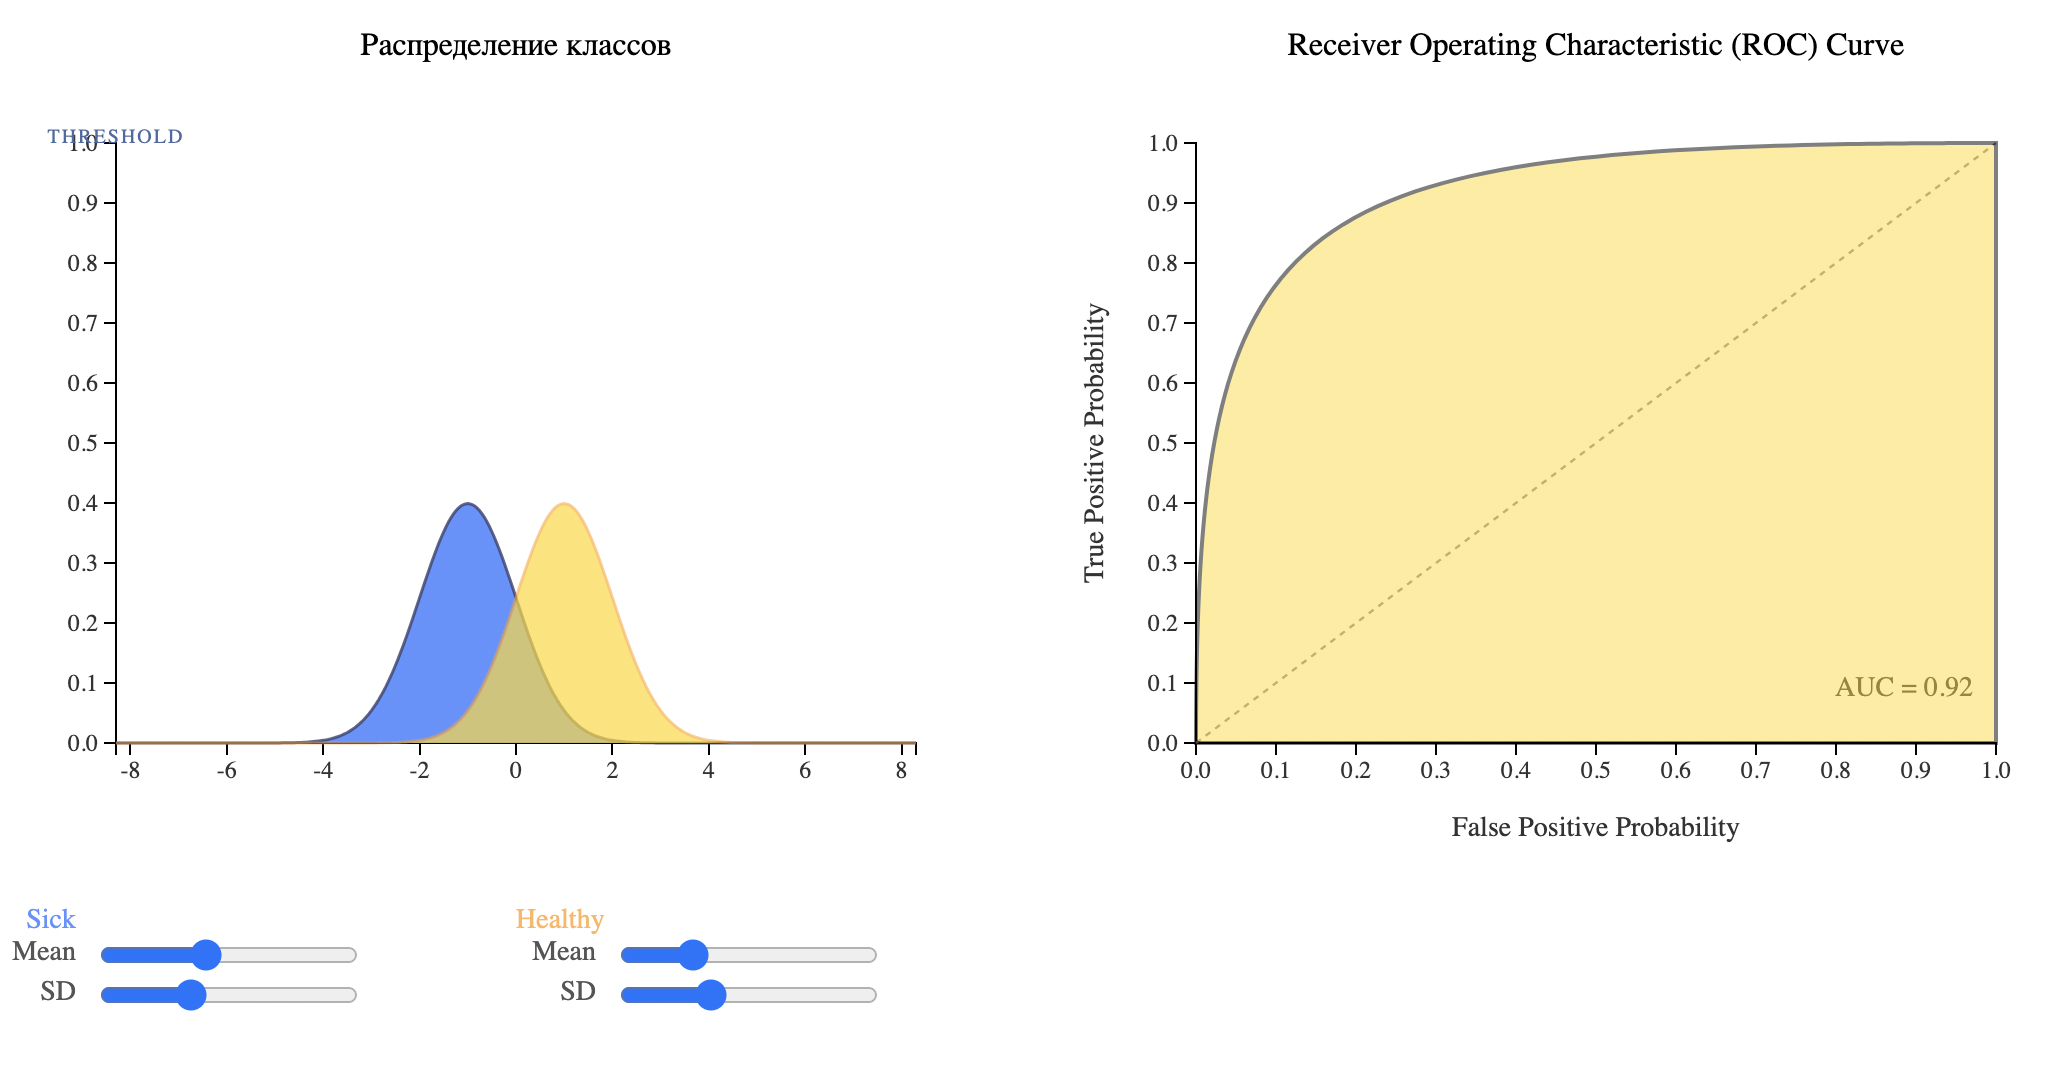

Желтая и синяя кривые показывают распределение предсказаний классификатора на объектах положительного и отрицательного классов соответственно. То есть значения на оси X (на графике с двумя гауссианами) мы получаем из классификатора. Если классификатор идеальный (две кривые разделимы по оси X), то на правом графике мы получаем ROC-кривую (0,0)->(0,1)->(1,1) (убедитесь сами!), площадь под которой равна 1. Если классификатор случайный (предсказывает одинаковые метки положительным и отрицательным объектам), то мы получаем ROC-кривую (0,0)->(1,1), площадь под которой равна 0.5. Поэкспериментируйте с разными вариантами распределения предсказаний по классам и посмотрите, как меняется ROC-кривая.

Чем лучше классификатор разделяет два класса, тем больше площадь (area under curve) под ROC-кривой – и мы можем использовать её в качестве метрики. Эта метрика называется AUC и она работает благодаря следующему свойству ROC-кривой:

AUC равен доле пар объектов вида (объект класса 1, объект класса 0), которые алгоритм верно упорядочил, т.е. предсказание классификатора на первом объекте больше:

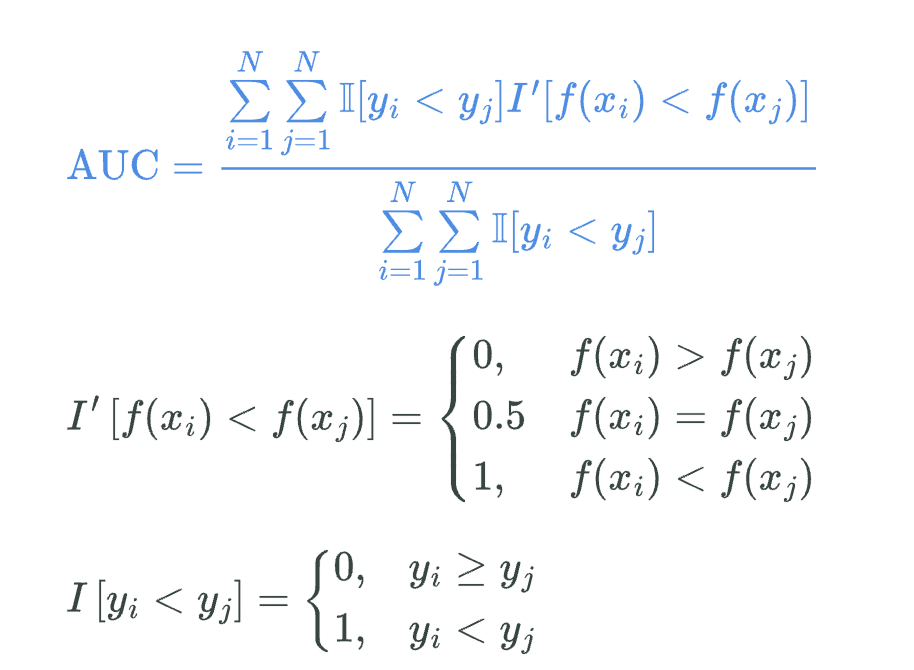

В каких случаях лучше отдать предпочтение этой метрике? Рассмотрим следующую задачу: некоторый сотовый оператор хочет научиться предсказывать, будет ли клиент пользоваться его услугами через месяц. На первый взгляд кажется, что задача сводится к бинарной классификации с метками 1, если клиент останется с компанией и 
 – иначе.

Однако если копнуть глубже в процессы компании, то окажется, что такие метки практически бесполезны. Компании скорее интересно упорядочить клиентов по вероятности прекращения обслуживания и в зависимости от этого применять разные варианты удержания: кому-то прислать скидочный купон от партнёра, кому-то предложить скидку на следующий месяц, а кому-то и новый тариф на особых условиях.

Таким образом, в любой задаче, где нам важна не метка сама по себе, а правильный порядок на объектах, имеет смысл применять AUC.

#### Average Precision

Будем постепенно уменьшать порог бинаризации. При этом полнота будет расти от 0 до 1, так как будет увеличиваться количество объектов, которым мы приписываем положительный класс (а количество объектов, на самом деле относящихся к положительному классу, очевидно, меняться не будет). Про точность же нельзя сказать ничего определённого, но мы понимаем, что скорее всего она будет выше при более высоком пороге отсечения (мы оставим только объекты, в которых модель «уверена» больше всего). Варьируя порог и пересчитывая значения Precision и Recall на каждом пороге, мы получим некоторую кривую примерно следующего вида:

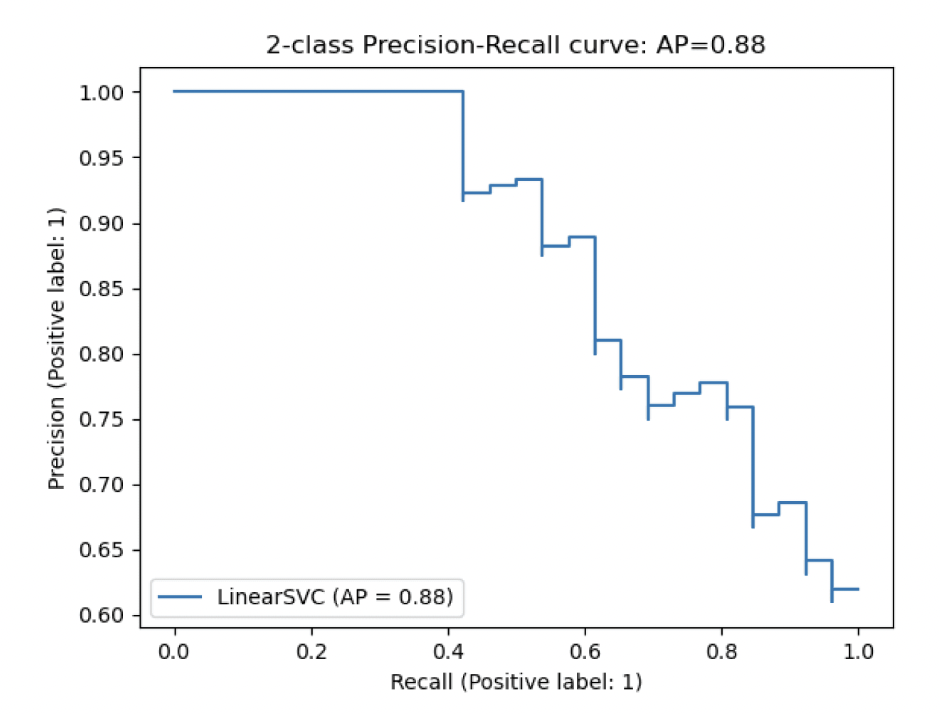

Рассмотрим среднее значение точности (оно равно площади под кривой точность-полнота):


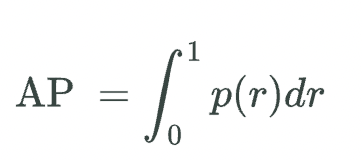

Получим показатель эффективности, который называется average precision. Как в случае матрицы ошибок мы переходили к скалярным показателям эффективности, так и в случае с кривой точность-полнота мы охарактеризовали ее в виде числа.

#### Переход к многоклассовой классификации


Если классов становится больше двух, расчёт метрик усложняется. Если задача классификации на K классов ставится как K задач об отделении класса i от остальных, то для каждой из них можно посчитать свою матрицу ошибок. Затем есть два варианта получения итогового значения метрики из K матриц ошибок:

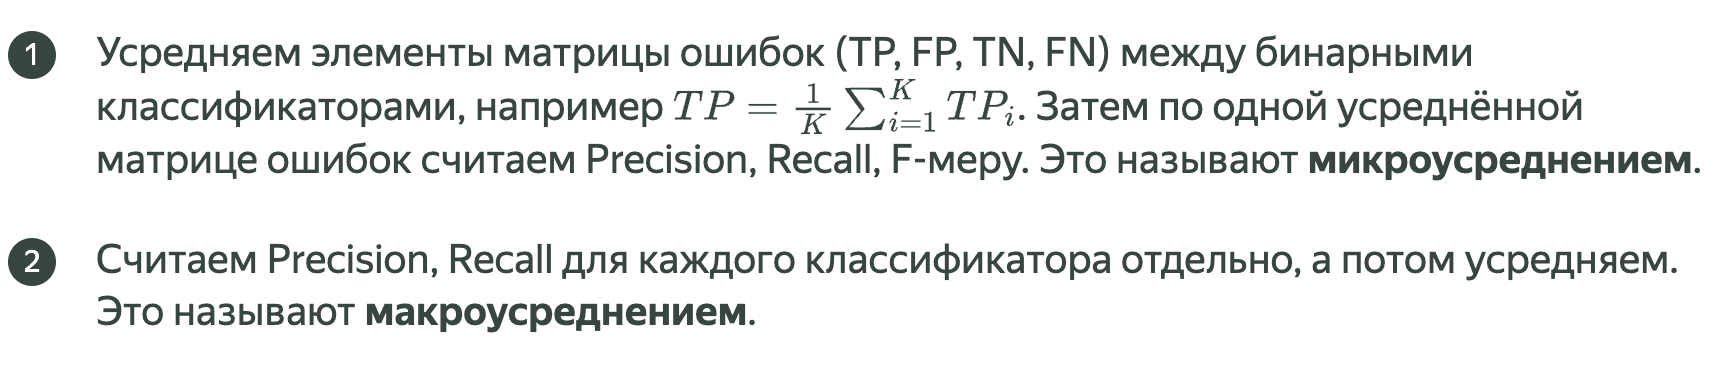

Первый вариант может неправильно отражать ситуацию, когда классы дисбалансные. Рассмотрим пример

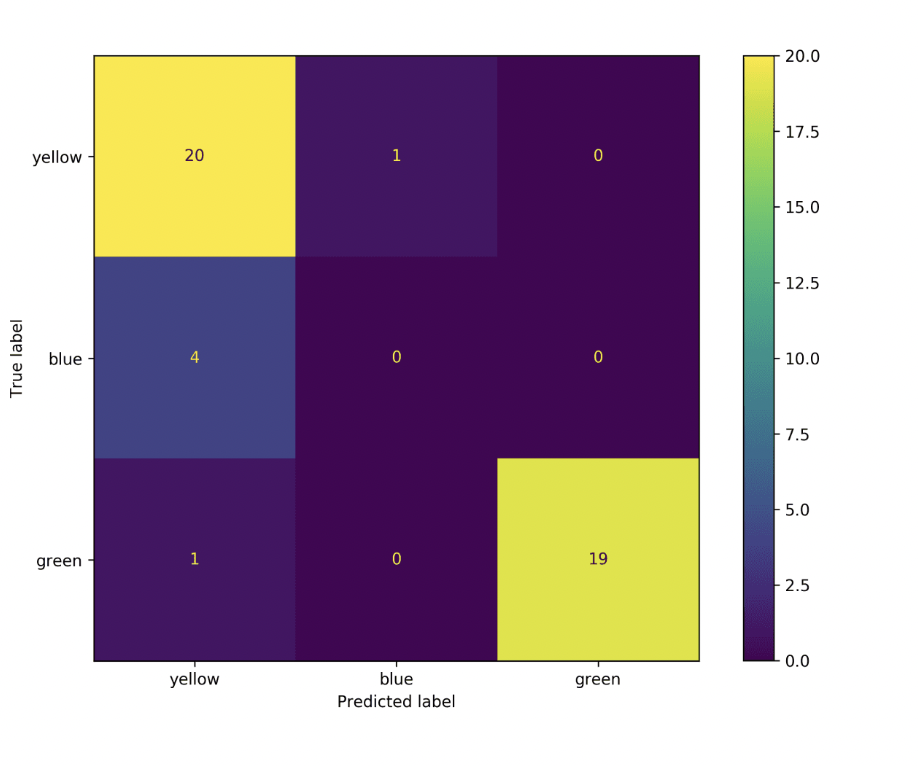

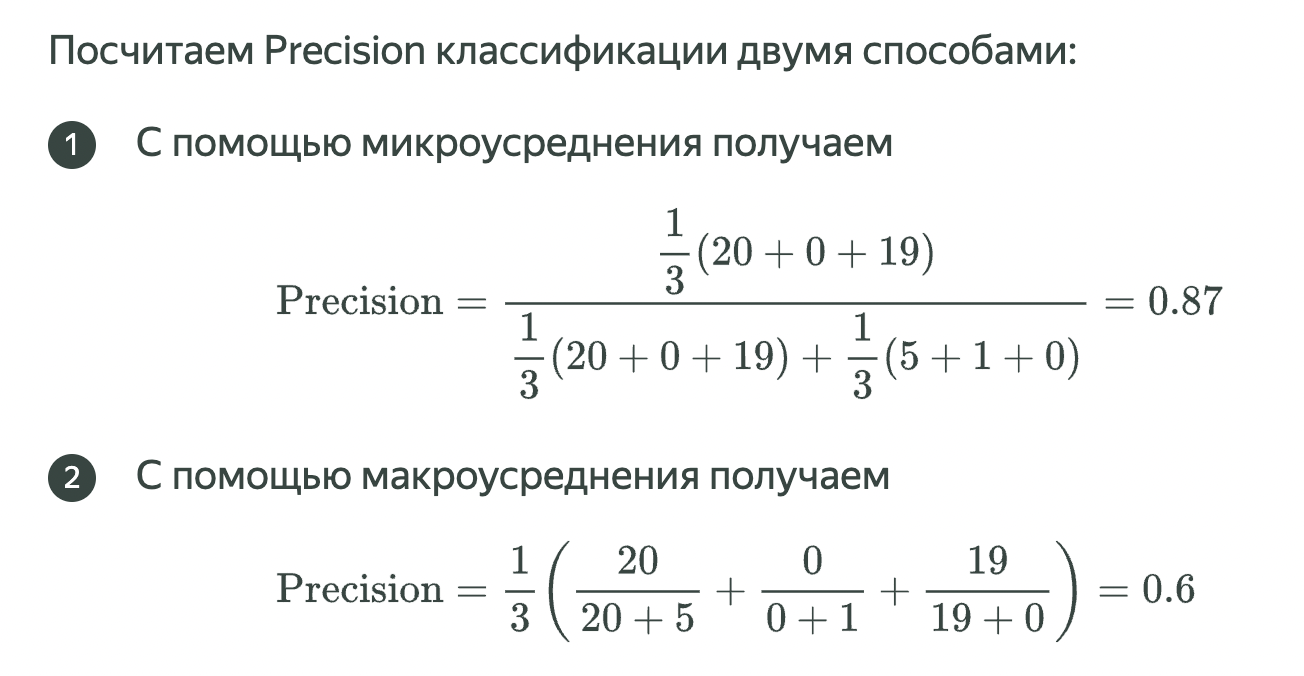

Видим, что макроусреднение лучше отражает тот факт, что синий цвет, которого в датасете было совсем мало, модель практически игнорирует.

#### Code part

In [53]:
import pandas as pd
from catboost import CatBoostClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

dt = pd.read_csv('assets/data_cancer.csv').drop(['Unnamed: 32', 'id'], axis=1).dropna()
dt['diagnosis'] = dt['diagnosis'].apply(lambda x: 0 if x == 'B' else 1)
train_dt, test_dt = train_test_split(dt)

model = CatBoostClassifier(verbose=False)

train_dt.head(3)

diagnosis  radius_mean  ...  symmetry_worst  fractal_dimension_worst
342          0        11.06  ...          0.3301                  0.09080
400          1        17.91  ...          0.3245                  0.11980
443          0        10.57  ...          0.2699                  0.06736

[3 rows x 31 columns]

In [54]:
train_dt['diagnosis'].mean(), test_dt['diagnosis'].mean()

(0.38497652582159625, 0.3356643356643357)

In [72]:
model.fit(
    X=train_dt.drop(['diagnosis'], axis=1),
    y=train_dt['diagnosis'],
)

y = test_dt['diagnosis']
preds = model.predict(test_dt.drop(['diagnosis'], axis=1))
prob_preds = model.predict_proba(test_dt.drop(['diagnosis'], axis=1))

In [73]:
print(f'accuracy: {metrics.accuracy_score(preds, y)}')
print(f'precision: {metrics.precision_score(preds, y)}')
print(f'recall: {metrics.recall_score(preds, y)}')
print(f'f1: {metrics.f1_score(preds, y)}')
print(f'f-2.0: {metrics.fbeta_score(preds, y, beta=2.0)}')
print(f'f-0.5: {metrics.fbeta_score(preds, y, beta=0.5)}')

accuracy: 0.951048951048951
precision: 0.8958333333333334
recall: 0.9555555555555556
f1: 0.924731182795699
f-2.0: 0.9429824561403511
f-0.5: 0.9071729957805909


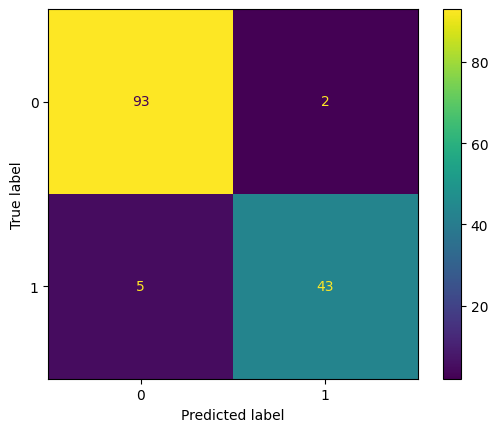

In [94]:
import matplotlib.pyplot as plt

display = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y, preds))
display.plot()
plt.show()

In [95]:
print(f'auc: {metrics.roc_auc_score(y, prob_preds[:, 1])}')
print(f'average precision: {metrics.average_precision_score(y, prob_preds[:, 1])}')

auc: 0.9789473684210527
average precision: 0.9729033910475448


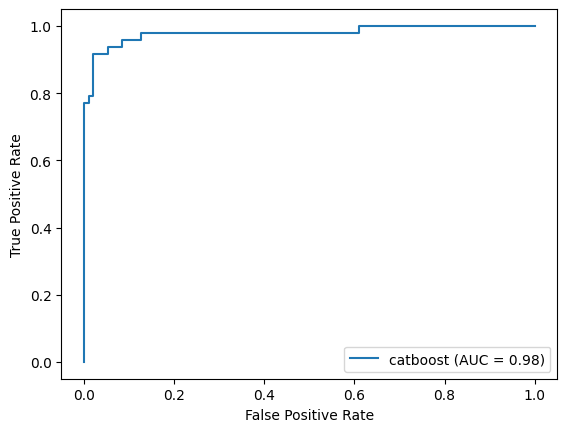

In [96]:
fpr, tpr, thresholds = metrics.roc_curve(y, prob_preds[:, 1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='catboost')
display.plot()
plt.show()

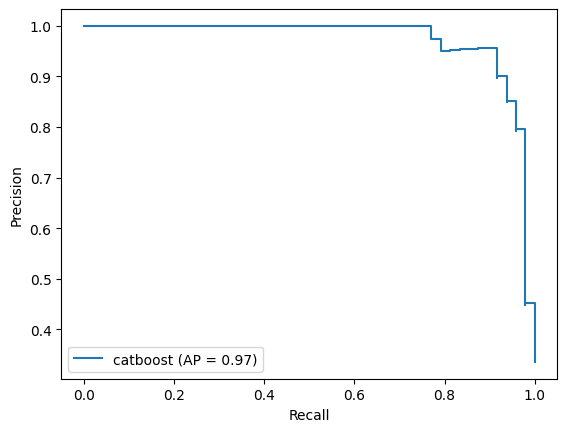

In [97]:
precision, recall, thresholds = metrics.precision_recall_curve(y, prob_preds[:, 1])
average_precision = metrics.average_precision_score(y, prob_preds[:, 1])
display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision,estimator_name='catboost')
display.plot()
plt.show()

# Code time

In [141]:
import pandas as pd

train_dt = pd.read_csv('assets/utk_vecs_train.csv')
test_dt = pd.read_csv('assets/utk_vecs_test.csv')

train_y, test_y = train_dt['age'], test_dt['age']
train_dt, test_dt = train_dt.drop(['age', 'gender', 'race'], axis=1), test_dt.drop(['age', 'gender', 'race'], axis=1)

dt.head(3)

age  gender  race       x_0  ...     x_508     x_509     x_510     x_511
0  10.0     0.0   0.0 -0.131650  ... -0.090889  1.669639  0.042681  0.194153
1  30.0     1.0   2.0  0.833633  ...  1.823555  0.984498  0.585643  0.252310
2  18.0     1.0   0.0 -1.804619  ... -0.376985 -1.300493  0.549910  0.626401

[3 rows x 515 columns]

In [142]:
from typing import *
import logging

import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import StackingRegressor
import sklearn.metrics as metrics
from sklearn.decomposition import PCA


class AutoMLRegressor(object):
    # def __init__(
    #     self,
    #     ...
    # ):
    #     ...

    def __clean_data(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray,
        test_dataframe: pd.DataFrame
    ) -> Tuple[pd.DataFrame, np.ndarray, pd.DataFrame]:
        train_dataframe['_target'] = train_y
        train_dataframe = train_dataframe.dropna()
        train_y = train_dataframe['_target']
        train_dataframe = train_dataframe.drop(['_target'], axis=1)

        for column in train_dataframe.columns:
            mean_value = train_dataframe[column].mean()
            test_dataframe[column].fillna(mean_value)
        
        return train_dataframe, train_y, test_dataframe

    def __handle_cat_features(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray,
        test_dataframe: pd.DataFrame
    ) -> Tuple[pd.DataFrame, np.ndarray, pd.DataFrame]:
        
        for column in train_dataframe.columns:
            if len(np.unique(np.concatenate([
                train_dataframe[column].values,
                test_dataframe[column].values,
            ]))) > 100:
                continue
            
            encoder = OneHotEncoder()
            encoder.fit(
                np.concatenate([
                    train_dataframe[column].values,
                    test_dataframe[column].values,
                ])
            )

            train_dataframe[[f'{column}_{i}' for i in range(len(categories_))]] = encoder.predict(train_dataframe[column].values)
            train_dataframe = train_dataframe.drop([column], axis=1)

            test_dataframe[[f'{column}_{i}' for i in range(len(categories_))]] = encoder.predict(test_dataframe[column].values)
            test_dataframe = test_dataframe.drop([column], axis=1)

        return train_dataframe, train_y, test_dataframe

    def __normalize_data(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray,
        test_dataframe: pd.DataFrame
    ) -> Tuple[pd.DataFrame, np.ndarray, pd.DataFrame]:

        mean_dataframe = pd.concat([train_dataframe, test_dataframe]).mean()
        std_dataframe = pd.concat([train_dataframe, test_dataframe]).std()
        
        train_dataframe = (train_dataframe - mean_dataframe) / std_dataframe
        test_dataframe = (test_dataframe - mean_dataframe) / std_dataframe

        return train_dataframe, train_y, test_dataframe
        
            
        

    def _data_engineering(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray,
        test_dataframe: pd.DataFrame
    ) -> Tuple[pd.DataFrame, np.ndarray, pd.DataFrame]:
        # Чистит данные, преобразуем фичи, балансирует и нормализует

        train_dataframe, train_y, test_dataframe  = self.__clean_data(
            train_dataframe, train_y, test_dataframe
        )
        
        train_dataframe, train_y, test_dataframe  = self.__handle_cat_features(
            train_dataframe, train_y, test_dataframe
        )

        train_dataframe, train_y, test_dataframe  = self.__normalize_data(
            train_dataframe, train_y, test_dataframe
        )

        return train_dataframe, train_y, test_dataframe

        
        

    def _feature_engineering(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray,
        test_dataframe: pd.DataFrame
    ) -> Tuple[pd.DataFrame, np.ndarray, pd.DataFrame]:
        pca = PCA(n_components=128)
        pca.fit(pd.concat([train_dataframe, test_dataframe]))
        return train_dataframe, train_y, test_dataframe
        
        # train_dataframe = pca.predict(train_dataframe)
        

    def _tune_linear_estimator(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray
    ):
        logging.info('Starting lasso estimator tune')
        grid = dict(
            alpha=[1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
        )
        
        search = GridSearchCV(
            estimator=Lasso(),
            param_grid=grid,
            scoring='neg_mean_absolute_percentage_error',
        )

        search.fit(
            train_dataframe.values,
            train_y
        )

        logging.info('Finishing lasso estimator tune')

        return search.best_estimator_

    def _tune_knn_estimator(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray
    ):
        logging.info('Starting knn estimator tune')
        grid = dict(
            n_neighbors=[1, 3, 5, 7, 11, 15, 19, 29, 51]
        )
        
        search = GridSearchCV(
            estimator=KNeighborsRegressor(),
            param_grid=grid,
            scoring='neg_mean_absolute_percentage_error',
        )

        search.fit(
            train_dataframe.values,
            train_y
        )

        logging.info('Finishing knn estimator tune')

        return search.best_estimator_

    def _tune_catboost_estimator(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray
    ):
        logging.info('Starting catboost estimator tune')
        model = CatBoostRegressor(verbose=False)
        model.fit(
            train_dataframe.values,
            train_y
        )
        logging.info('Finishing catboost estimator tune')
        return model
        

    def fit_predict(
        self,
        train_dataframe: pd.DataFrame,
        train_y: np.ndarray,
        test_dataframe: pd.DataFrame
    ) -> np.ndarray:

        # logging.info('Starting Data engineering')
        # train_dataframe, train_y, test_dataframe = self._data_engineering(train_dataframe, train_y, test_dataframe)
        # logging.info('Finishing Data engineering')

        # logging.info('Starting Feature engineering')
        # train_dataframe, train_y, test_dataframe = self._feature_engineering(train_dataframe, train_y, test_dataframe)
        # logging.info('Finishing Feature engineering')

        best_linear_estimator = self._tune_linear_estimator(train_dataframe, train_y)
        best_knn_estimator = self._tune_knn_estimator(train_dataframe, train_y)
        best_catboost_estimator = self._tune_catboost_estimator(train_dataframe, train_y)

        # logging.info('Stacking fit staring')
        # stacking = StackingRegressor(
        #     estimators=[('lasso', best_linear_estimator), ('knn', best_knn_estimator), ('catboost', best_catboost_estimator)],
        #     final_estimator=Lasso()
        # )

        # stacking.fit(train_dataframe, train_y)
        # logging.info('Stacking fit ending')


        return (best_linear_estimator.predict(test_dataframe) + best_knn_estimator.predict(test_dataframe) + best_catboost_estimator.predict(test_dataframe)) / 3

In [143]:
auto_ml = AutoMLRegressor()

In [144]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

predictions = auto_ml.fit_predict(
    train_dt,
    train_y,
    test_dt
)

INFO:root:Starting lasso estimator tune
INFO:root:Finishing lasso estimator tune
INFO:root:Starting knn estimator tune
INFO:root:Finishing knn estimator tune
INFO:root:Starting catboost estimator tune
INFO:root:Finishing catboost estimator tune
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [145]:
metrics.mean_absolute_error(predictions, test_y)

6.726902080891519